# Importing the Libraries

In [71]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#Sampling
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
#Scaling
from sklearn.preprocessing import MinMaxScaler

# Importing the dataset

In [73]:
dataset = pd.read_csv('bank-additional-full.csv', sep=';', quotechar='"')

In [74]:
dataset_copy = dataset.copy()

#### Reordering the columns order as numerical to categorical

In [75]:
# Separate numerical and categorical columns
numerical_columns = dataset_copy.select_dtypes(include='number').columns.tolist()
categorical_columns = dataset_copy.select_dtypes(exclude='number').columns.tolist()

# Reorder the dataset as starting with numerical columns then categorical
new_order = numerical_columns + categorical_columns
dataset_copy = dataset_copy[new_order]

## Defining required functions:

In [76]:
def visualize_features(df,column_name):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column_name, kde=True, color='skyblue')
    plt.title(f"Distribution of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [77]:
def visualize_target_feature(df,column_name):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column_name, hue='y', multiple='stack', palette='Set2')
    plt.title(f"Distribution of 'y' within {column_name} Groups")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [78]:
def visualize_outliers(df, column_name):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=column_name, color='skyblue')
    plt.title(f"Boxplot of {column_name} (with Outliers)")
    plt.xlabel(column_name)
    plt.tight_layout()
    plt.show()

In [79]:
def correlation_heatmap(df,numerical_col):
    ## taking from https://github.com/bowcai/bank-analysis/blob/main/bank-analysis.ipynb
    fig= plt.figure(figsize=(8,8))

    corr = df[numerical_col].corr()
    mask = np.triu(df[numerical_col].corr())

    axes = fig.add_axes([0, 0, 1, 1])
    sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
                linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

In [80]:
def visualize(df,column_name):
    visualize_features(df,column_name)
    visualize_target_feature(df,column_name)
    visualize_outliers(df, column_name)

In [81]:
def remove_outliers_by_quantiles(df, column_name, lower_quantile=0.01, upper_quantile=0.99):
    lower_bound = df[column_name].quantile(lower_quantile)
    upper_bound = df[column_name].quantile(upper_quantile)
    df.drop(df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)].index, inplace=True)

In [82]:
def extract_feature_by_thresholds(df,col_name,thresholds):
    labels = []
    for i in range(len(thresholds) - 1):
        label = f"{col_name}_({thresholds[i]}_{thresholds[i+1]}]"
        mask = (df[col_name] > thresholds[i]) & (df[col_name] <= thresholds[i+1])
        df.loc[mask, f'{col_name}_group'] = label
        labels.append(label)

In [83]:
def print_extract_feature_by_thresholds(df,col_name,thresholds):
    percentages = {}
    total_samples = len(df)
    for i in range(len(thresholds) - 1):
        lower_bound = thresholds[i]
        upper_bound = thresholds[i + 1]
        mask = (df[col_name] > lower_bound) & (df[col_name] <= upper_bound)
        count = df.loc[mask].shape[0]
        percentage = (count / total_samples)
        rounded_percentage = round(percentage, 4)
        print(f"({lower_bound}_{upper_bound}] = {rounded_percentage}, samples:{count}")

In [84]:
def calculate_success_rate(df, feature_column, target_column, lower_bound,upper_bound):
    # Filter the DataFrame for the specific condition
    filtered_df = df[(df[feature_column] >= lower_bound) & (df[feature_column] <= upper_bound)].copy()
    # Group by the feature column and calculate the rate of 'yes' for each unique value
    grouped = filtered_df.groupby(feature_column)[target_column].apply(lambda x: (x == 'yes').mean())
    success_rate = grouped.mean()
    return grouped, success_rate

In [85]:
def generate_start_end_threshold(df, col_name, increment_range):
    start = df[col_name].min() - (df[col_name].min())%increment_range
    end = df[col_name].max() - (df[col_name].max())%increment_range + increment_range
    return start, end

In [86]:
def generate_threshold(df,col_name,increment_range):
    start, end = generate_start_end_threshold(df,col_name,increment_range)
    thresholds = []
    threshold = start
    while threshold <= end:
        thresholds.append(threshold)
        threshold += increment_range
    return thresholds

# Data Visualization

In [87]:
# for col in dataset_copy.columns:
#     visualize_features(dataset_copy,col)

# Handling outliers

In [88]:
for col_name in numerical_columns:
    remove_outliers_by_quantiles(dataset_copy,col_name)

# Handling missing values

In [89]:
# Only categorical features has missing values
print(dataset_copy[categorical_columns].isin(['unknown']).sum())

job             289
marital          70
education      1473
default        8220
housing         892
loan            892
contact           0
month             0
day_of_week       0
poutcome          0
y                 0
dtype: int64


In [90]:
# Replacing the "unknown" with np.nan
dataset_copy.replace('unknown', np.nan, inplace=True)
dataset_copy.fillna(dataset_copy.mode().iloc[0], inplace=True)

# Feature Extraction:

##### 1-) "Age"

In [91]:
age_threshold = generate_threshold(dataset_copy,'age',5)
print(age_threshold)

[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]


In [92]:
print_extract_feature_by_thresholds(dataset_copy,'age',age_threshold)

(20_25] = 0.0305, samples:1138
(25_30] = 0.139, samples:5188
(30_35] = 0.2263, samples:8447
(35_40] = 0.1823, samples:6806
(40_45] = 0.1413, samples:5273
(45_50] = 0.1164, samples:4345
(50_55] = 0.0898, samples:3352
(55_60] = 0.0649, samples:2423
(60_65] = 0.0053, samples:198
(65_70] = 0.0035, samples:131
(70_75] = 0.0008, samples:29


In [93]:
extract_feature_by_thresholds(dataset_copy,'age',age_threshold)

##### 2-) "duration"

In [94]:
duration_threshold = generate_threshold(dataset_copy,'duration',100)
print(duration_threshold)

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300]


In [95]:
print_extract_feature_by_thresholds(dataset_copy,'duration',duration_threshold)

(0_100] = 0.2428, samples:9065
(100_200] = 0.3155, samples:11777
(200_300] = 0.1759, samples:6568
(300_400] = 0.099, samples:3695
(400_500] = 0.055, samples:2055
(500_600] = 0.0359, samples:1341
(600_700] = 0.025, samples:935
(700_800] = 0.0172, samples:643
(800_900] = 0.0116, samples:434
(900_1000] = 0.0081, samples:304
(1000_1100] = 0.0063, samples:237
(1100_1200] = 0.0048, samples:180
(1200_1300] = 0.0026, samples:96


In [96]:
extract_feature_by_thresholds(dataset_copy,'duration',duration_threshold)

##### 3-) "pdays"

In [97]:
dataset_copy['pdays_group'] = dataset_copy['pdays']
dataset_copy.loc[dataset_copy['pdays'] <= 100, 'pdays_group'] = 0
dataset_copy.loc[dataset_copy['pdays'] > 100, 'pdays_group'] = 1

In [98]:
print(dataset_copy['pdays_group'].value_counts())

pdays_group
1    36566
0      764
Name: count, dtype: int64


##### 4-) "emp.var.rate"

In [99]:
dataset_copy['emp.var.rate_sign'] = dataset_copy['emp.var.rate']
dataset_copy.loc[dataset_copy['emp.var.rate'] < 0, 'emp.var.rate_sign'] = -1    # negative employment variation rate
dataset_copy.loc[dataset_copy['emp.var.rate'] > 0, 'emp.var.rate_sign'] = 1     # positive employment variation rate

In [100]:
print(dataset_copy['emp.var.rate_sign'].value_counts())

emp.var.rate_sign
 1.0    23000
-1.0    14330
Name: count, dtype: int64


##### 5-) "cons.conf.idx"

In [101]:
cons_conf_idx_threshold = generate_threshold(dataset_copy,'cons.conf.idx',5)
print(cons_conf_idx_threshold)

[-50.0, -45.0, -40.0, -35.0, -30.0, -25.0]


In [102]:
print_extract_feature_by_thresholds(dataset_copy,'cons.conf.idx',cons_conf_idx_threshold)

(-50.0_-45.0] = 0.2107, samples:7866
(-45.0_-40.0] = 0.4057, samples:15143
(-40.0_-35.0] = 0.3433, samples:12814
(-35.0_-30.0] = 0.0342, samples:1275
(-30.0_-25.0] = 0.0062, samples:232


In [103]:
extract_feature_by_thresholds(dataset_copy,'cons.conf.idx',cons_conf_idx_threshold)

# Encoding features:

In [104]:
print(categorical_columns)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


In [105]:
label_encoded_features = ['age_group','duration_group','cons.conf.idx_group',
                          'education','default','housing','loan','month',
                          'day_of_week','poutcome','marital','contact','y']
onehot_encoded_features = ['job']

In [106]:
ohe = OneHotEncoder()
label_encoder = LabelEncoder()

for col in onehot_encoded_features:
    transformed = ohe.fit_transform(dataset_copy[[col]])
    dataset_copy[ohe.categories_[0]] = transformed.toarray()

for column in label_encoded_features:
    dataset_copy[column] = label_encoder.fit_transform(dataset_copy[column])

# Feature Sampling:

In [107]:
X = dataset_copy.drop(['y','job'], axis=1)
y = dataset_copy['y']

In [108]:
counter = Counter(y)
print(f"Before oversampling:{counter}")

oversampling = SMOTE()
X, y = oversampling.fit_resample(X, y)

counter = Counter(y)
print(f"After oversampling:{counter}")

Before oversampling:Counter({0: 34138, 1: 3192})
After oversampling:Counter({0: 34138, 1: 34138})


# Feature Reduction:

<Axes: >

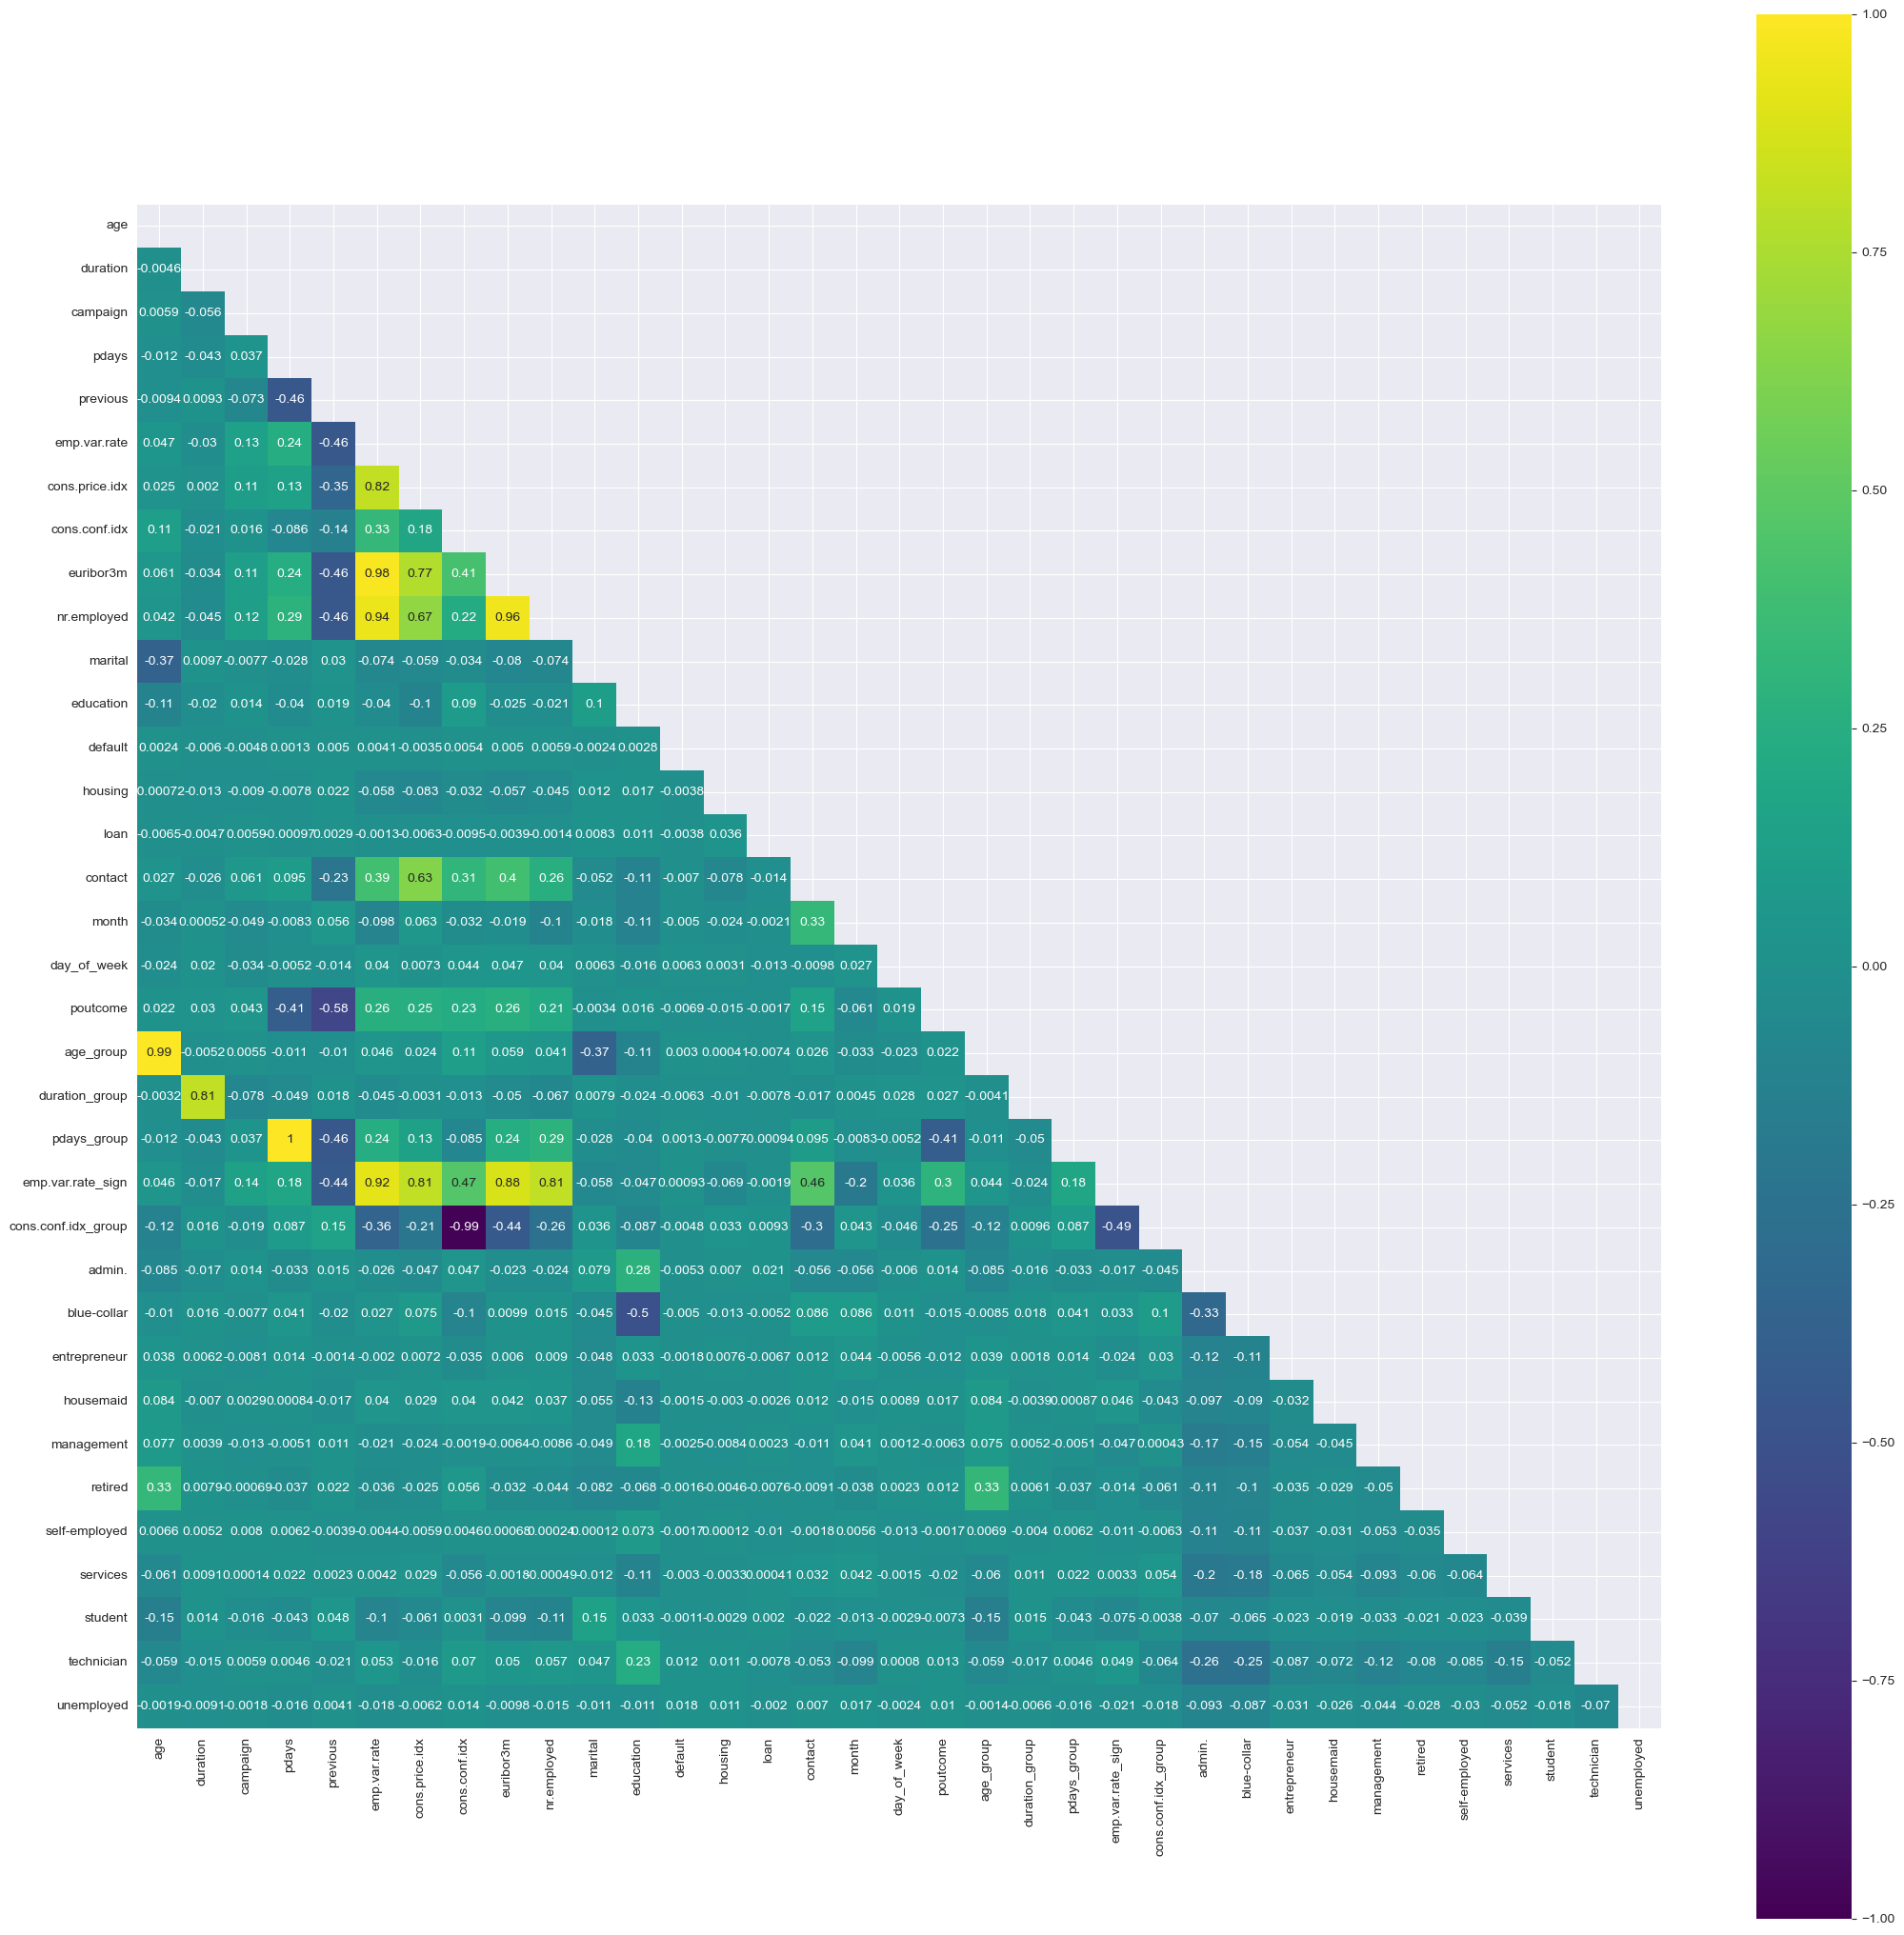

In [109]:
fig= plt.figure(figsize=(20,20))
df = dataset_copy.drop(['y','job'], axis=1)
corr = df.corr()
mask = np.triu(df.corr())

axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
            linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

In [ ]:
# Since there is a huge correlation between emp.var.rate and (cons.price.idx/euribor3m/nr.employed)
# we drop those features
dataset_copy = dataset_copy.drop(['age','duration','pdays','emp.var.rate','cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)
numerical_columns = dataset_copy.select_dtypes(include='number').columns.tolist()

In [ ]:
correlation_heatmap(dataset_copy,numerical_columns)

# Feature Scaling:

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)